In [1]:
import ceo
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
#import scipy
#import cupyx.scipy.signal

/home/ubuntu/CEO/python/ceo/zemax


# Holographic Dispersed Fringe Sensor Demo
Sensor designed by Sebastiaan Haffert, optimized for NGWS 2nd channel application.

## Initialize Telescope

In [2]:
gmt = ceo.GMT_MX()
#gmt.M2_baffle = 3.6    # Circular diameter pupil mask obscuration
gmt.project_truss_onaxis = False

PupilArea = 356.0 # m2
D = 25.5

## HDFS and GS initialization

In [3]:
mag = 10.0
tel_throughput = 0.9**4 # M1 + M2 + M3 + GMTIFS dichroic = 0.9^4
ngws_throughput =  tel_throughput * 0.4  # NGWS board: 0.4
sps_throughput  = ngws_throughput * 0.1  # light sent to 2nd visible channel

In [5]:
# DFS GS custom band
wl2nd = 810e-9
delta_wl2nd = 220e-9
wvl_band = [wl2nd-delta_wl2nd/2.,wl2nd+delta_wl2nd/2.]

#---- Scale zeropoint for the desired bandwidth:
e0_RIband = 9e12 # zeropoint in photons/s in R+I band over the GMT pupil (check official photometry table!)
delta_wl_RIband = 300e-9  # check official photometry table!
e0_wl2nd = e0_RIband * (delta_wl2nd/delta_wl_RIband) / PupilArea    #in ph/m^2/s in the desired bandwidth
print("Zero point [ph/m^2/s]: %.3e"%e0_wl2nd)
#print('Zero point [ph/s]: %.3e'%(e0_RIband * (delta_wl2nd/delta_wl_RIband)))
sps_band = [wl2nd, delta_wl2nd, e0_wl2nd]
mask_rotation = np.deg2rad(0.0)

sps_nPx = 512         # number of rays to propagate from GS to SPS
sps_pixelSize = D/(sps_nPx-1)

sps_mag = [mag]
gsps = ceo.Source(sps_band, magnitude=sps_mag, zenith=0.,azimuth=0.,
                  rays_box_size=D,rays_box_sampling=sps_nPx,rays_origin=[0.0,0.0,25])
gsps.rays.rot_angle = mask_rotation

print('Photometry in custom band:')
for x in range(gsps.N_SRC):
    print('Number of simulated GS photons [ph/m^2/s]: %.1f'%(gsps.nPhoton[x]*sps_throughput))
    # ---- Expected flux without vignetting (i.e. on-axis GS)
    print('Number of  expected GS photons [ph/m^2/s]: %.1f'%(sps_throughput*e0_wl2nd*10**(-0.4*sps_mag[x])))

Zero point [ph/m^2/s]: 1.854e+10
Photometry in custom band:
Number of simulated GS photons [ph/m^2/s]: 48654.6
Number of  expected GS photons [ph/m^2/s]: 48654.6


In [6]:
hdfs_design = 'v2a'
sps_achromatic_mask = False
sps_dispersion = 0 #not a design parameters
sps_lobe_detection = 'peak_value'      

if hdfs_design == 'v1':
    sps_fringe_window_size_mas = 190
    sps_fov = 1.4 #arcsec diameter
else:
    sps_fringe_window_size_mas = 140
    sps_fov = 1.0 #arcsec diameter

sps_fp_pxscl_mas = 2.4  #mas
sps_spectral_type='tophat'
sps_apodization_window_type='Tukey'
sps_processing_method='DFS'
sps_fs_shape = 'round'
sps_fs_dim_mas = 50 # field stop radius [mas]
sps_qe_model = 'ProEM'
sps_sky_bkgd_model = 'equivalent_sky_magnitude'
bkgd_mag = 19.6       # sky bkgd (mag/arcsec^2); Tech Note GMT-02274, rev 2.4


sps_RONval = 0.5            # [e- rms]
sps_emccd_gain = 1
sps_ADU_gain = 1.0 #1/2.76 # ProEM when readout speed set to 30 MHz (see HDFS design report, GMT-DOC-05337, Figure 9-7)
sps_emccd_nbits = 14
sps_darkCurrent = 0.01 # Feautrier et al, Characterization of OCam and CCD220, the fastest and most sensitive camera to date for AO wavefront sensing
sps_simul_phot = True
sps_simul_bkgd = False
sps_seed = 1928

ps = ceo.HolographicDFS(hdfs_design=hdfs_design, wvl_band=wvl_band, wvl_res=10e-9, 
            fov_mas=sps_fov*1e3, fp_pxscl_mas=sps_fp_pxscl_mas,
            fs_shape=sps_fs_shape,fs_dim_mas=sps_fs_dim_mas, spectral_type=sps_spectral_type,
            fringe_window_size_mas=sps_fringe_window_size_mas, apodization_window_type=sps_apodization_window_type,
            processing_method=sps_processing_method, throughput=sps_throughput,
            qe_model=sps_qe_model, sky_bkgd_model=sps_sky_bkgd_model, achromatic_mask=sps_achromatic_mask)

ps.camera.readoutNoiseRms = sps_RONval
ps.camera.EM_gain = sps_emccd_gain
ps.camera.ADU_gain = sps_ADU_gain
ps.camera.nbits = sps_emccd_nbits
ps.camera.darkCurrent = sps_darkCurrent

Filename: /home/ubuntu/CEO/python/ceo/sensors/ngws_hdfs_phase_design_v2a.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  MASK          1 PrimaryHDU      11   (512, 512)   float64   
  1  PAIRS         1 ImageHDU         8   (2, 7)   int64   
  2  BASELINE      1 ImageHDU         7   (7,)   float64   
  3  ANGLE         1 ImageHDU         7   (7,)   float64   
  4  OFFSET        1 ImageHDU         7   (7,)   float64   


## HDFS calibration
1. Stores pointers to GS wavefront (to avoid GPU-CPU transfers)
2. Computes the reference measurement vector (for a flat WF)

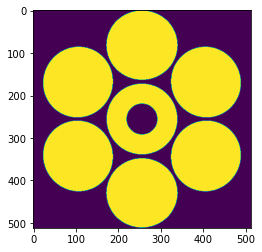

In [7]:
gmt.reset()
gsps.reset()
gmt.propagate(gsps)

plt.imshow(gsps.amplitude.host())
GMTmask = gsps.amplitude.host()
#np.savez('maskpup.npz', GMTmask=GMTmask, D=25.5)

HDFS total flux should be equal to one, but we get: 0.438982


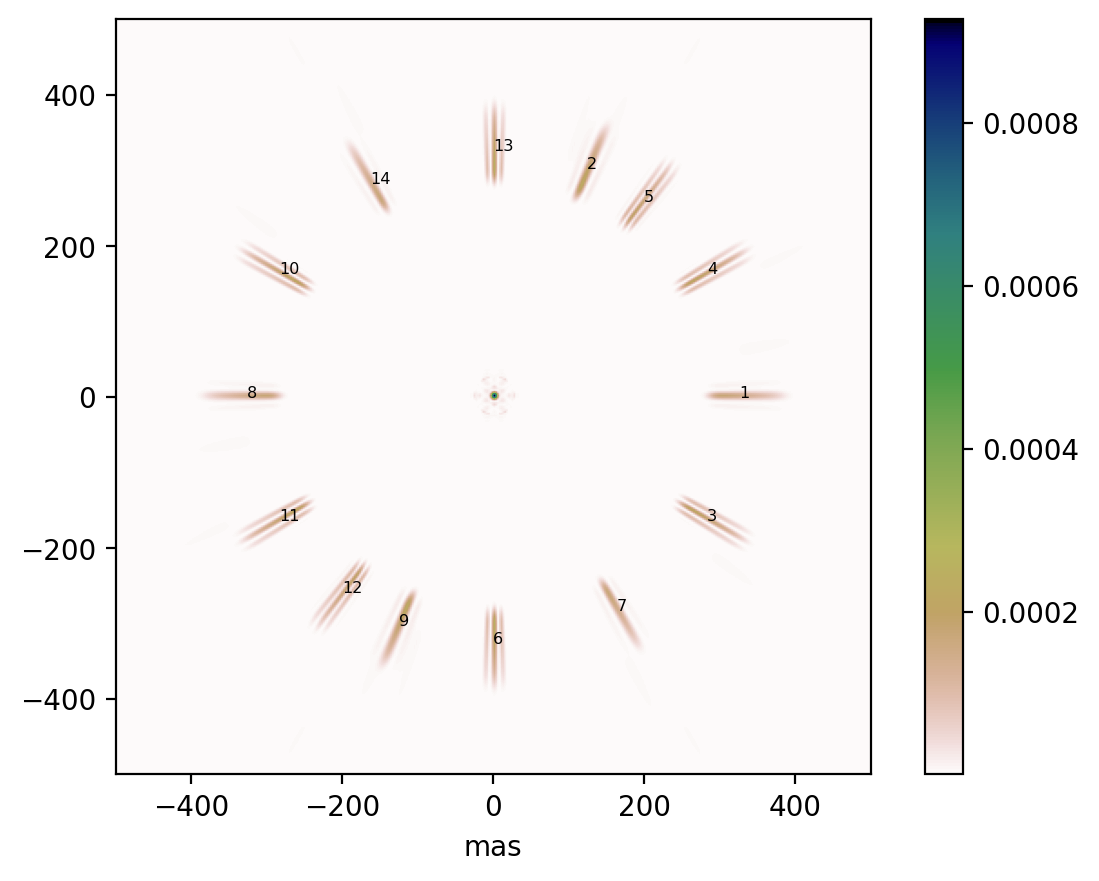

In [8]:
gmt.reset()
gsps.reset()
gmt.propagate(gsps)
ps.calibrate(gsps)

sps_flux_unitary_norm = cp.sum(ps._image)
print('HDFS total flux should be equal to one, but we get: %f'%sps_flux_unitary_norm)

fig, ax1 = plt.subplots()
fig.set_size_inches((7,5))
fig.dpi = 200
imm1 = ax1.imshow(ps._image.get(), origin='lower', cmap=plt.cm.gist_earth_r,
        extent=[ps._im_range_mas[0],ps._im_range_mas[1],ps._im_range_mas[0],ps._im_range_mas[1]])
ax1.set_xlabel('mas')
clb1 = fig.colorbar(imm1, ax=ax1)


fringe_loc_y_mas = (ps._fringe_loc_y_pix - ps._im_sz // 2)*ps._fp_pxscl_mas
fringe_loc_x_mas = (ps._fringe_loc_x_pix - ps._im_sz // 2)*ps._fp_pxscl_mas

#ax1.plot(fringe_loc_y_mas, fringe_loc_x_mas, 'o')
for jj in range(ps._N_FRINGES):
    ax1.text(fringe_loc_y_mas[jj], fringe_loc_x_mas[jj], str(jj+1), fontsize='xx-small')

In [9]:
def show_fringes(fringes=None, apodize=True, normalize=False, derotate=True, full=True, 
                 fig=None, ax=None, show_ids=True):
    if fringes is None:
        fringes = ps.extract_fringes(apodize=apodize, normalize=normalize, derotate=derotate)
    if full:
        if fig is None:
            fig, ax = plt.subplots(ncols=ps._N_FRINGES//2, nrows=2)
            fig.set_size_inches((10,3))
            fig.dpi=300
        for k in range(ps._N_FRINGES):
            (ax.ravel())[k].imshow(fringes[:,:,k].get(), cmap=plt.cm.gist_earth_r)#, origin='lower')
            (ax.ravel())[k].autoscale(False)
            if show_ids == True:
                (ax.ravel())[k].set_title('%d'%(k%ps._N_FRINGES+1), fontsize=12)
            (ax.ravel())[k].axis('off')
    else:
        if fig is None:
            fig, ax = plt.subplots(ncols=ps._N_FRINGES//2, nrows=1)
            fig.set_size_inches((10,1.5))
            fig.dpi = 300
        
        for k in range(ps._N_FRINGES//2):
            (ax.ravel())[k].imshow(fringes[:,:,k].get(), cmap=plt.cm.gist_earth_r)#, origin='lower')
            (ax.ravel())[k].autoscale(False)
            if show_ids == True:
                (ax.ravel())[k].set_title('%d'%(k%ps._N_FRINGES+1), fontsize=12)
            (ax.ravel())[k].axis('off')

    fig.tight_layout()

def show_fftlets(absfft=None, full=True, fig=None, ax=None, show_ids=True):
    if absfft is None:
        fringes = ps.extract_fringes(apodize=True, derotate=True)
        absfft = []
        for k in range(ps._N_FRINGES):
            absfft += [cp.fft.fftshift(cp.abs(cp.fft.fft2(fringes[:,:,k]))).get()]
            
    if full:
        if fig is None:
            fig, ax = plt.subplots(ncols=ps._N_FRINGES//2, nrows=2)
            fig.set_size_inches((10,3))
            fig.dpi=300
        for k in range(ps._N_FRINGES):
            (ax.ravel())[k].imshow(absfft[k], cmap=plt.cm.gist_earth_r, origin='lower')
            (ax.ravel())[k].autoscale(False)
            if show_ids == True:
                (ax.ravel())[k].set_title('%d'%(k%ps._N_FRINGES+1), fontsize=12)
            (ax.ravel())[k].axis('off')
    else:
        if fig is None:
            fig, ax = plt.subplots(ncols=ps._N_FRINGES//2, nrows=1)
            fig.set_size_inches((10,1.5))
            fig.dpi = 300
        for k in range(int(ps._N_FRINGES/2)):
            (ax.ravel())[k].imshow(absfft[k], cmap=plt.cm.gist_earth_r, origin='lower')
            (ax.ravel())[k].autoscale(False)
            if show_ids == True:
                (ax.ravel())[k].set_title('%d'%(k%ps._N_FRINGES+1), fontsize=12)
            (ax.ravel())[k].axis('off')

    fig.tight_layout()

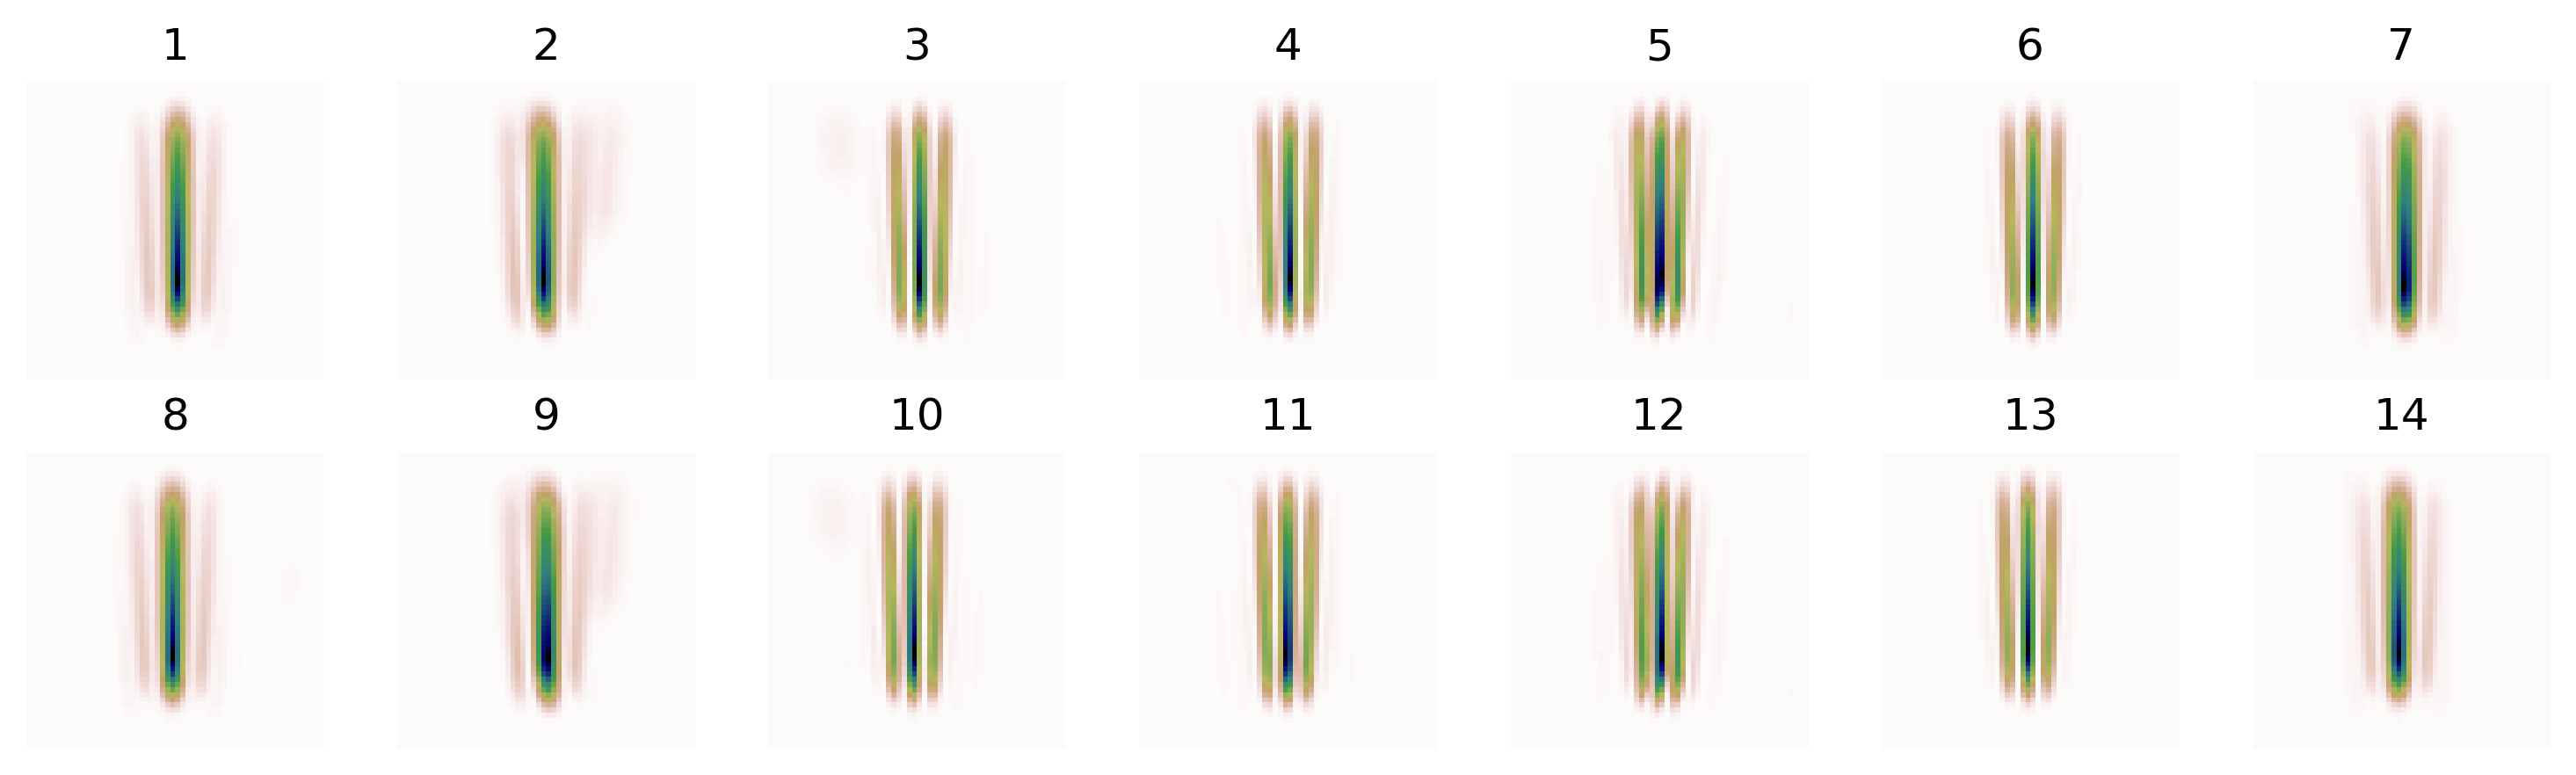

In [10]:
show_fringes(apodize=True, derotate=True, full=True)

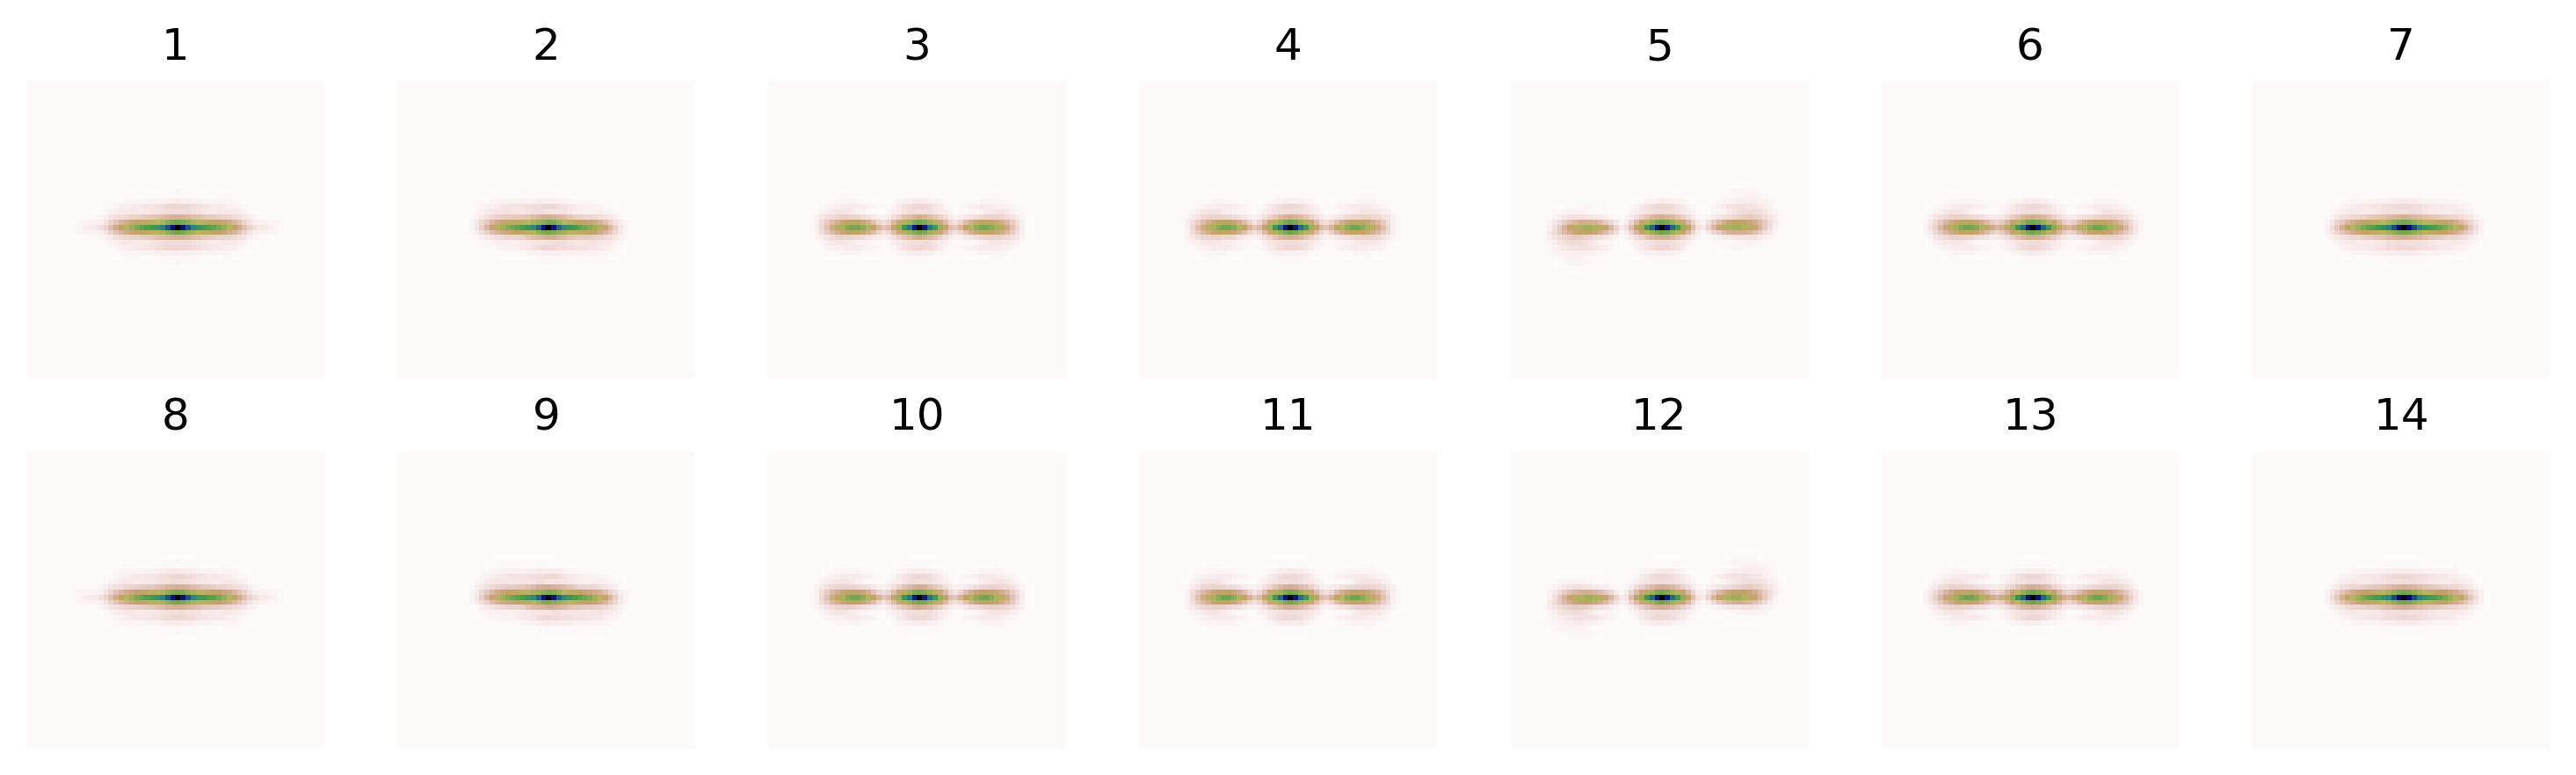

In [11]:
show_fftlets()

### Verify position of sidelobe

In [12]:
#--- Compute FFTlets to verify position of sidelobe
fringes = ps.extract_fringes(apodize=True, derotate=True)
absfft = []
for k in range(ps._N_FRINGES):
    absfft += [cp.fft.fftshift(cp.abs(cp.fft.fft2(fringes[:,:,k]))).get()]

In [13]:
profvec = np.arange(-ps._fringe_subframe_pix//2, ps._fringe_subframe_pix//2)

Text(0.5, 1.0, 'FFTlet Profile')

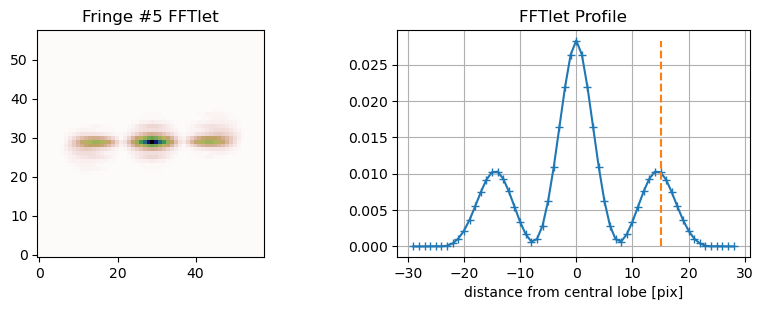

In [14]:
#--- Select FFTlet and show profile to verify sidelobe position
k=4

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
fig.dpi=100

ax1.imshow(absfft[k], cmap=plt.cm.gist_earth_r, origin='lower')
ax1.set_title('Fringe #%d FFTlet'%(k+1))
ax2.plot(profvec, absfft[k][ps._fringe_subframe_pix//2,:], '+-')
ax2.grid()
#ax2.set_xlim([0,ps._fringe_subframe_pix//2 - 5])
ax2.plot([ps._sidelobeloc[k] - ps._fringe_subframe_pix//2]*2, [0,np.max(absfft[k])],'--')
ax2.set_xlabel('distance from central lobe [pix]')
ax2.set_title('FFTlet Profile')

## Fringes processing demo
For a flat WF show processing steps:
1. show unrotated and raw fringes
2. show rotated and apodized fringes

For a piston-scrambled WF show processing steps:
1. Show rotated and apodized fringes
2. Show fftlets and profile

### Flat wavefront case

In [15]:
#-- Flat WF data
gmt.reset()
gsps.reset()
ps.reset()
gmt.propagate(gsps)
ps.propagate(gsps)

fringes00 = ps.extract_fringes(apodize=False, derotate=False)
fringes01 = ps.extract_fringes(apodize=False, derotate=True)
fringes02 = ps.extract_fringes(apodize=True, derotate=True)

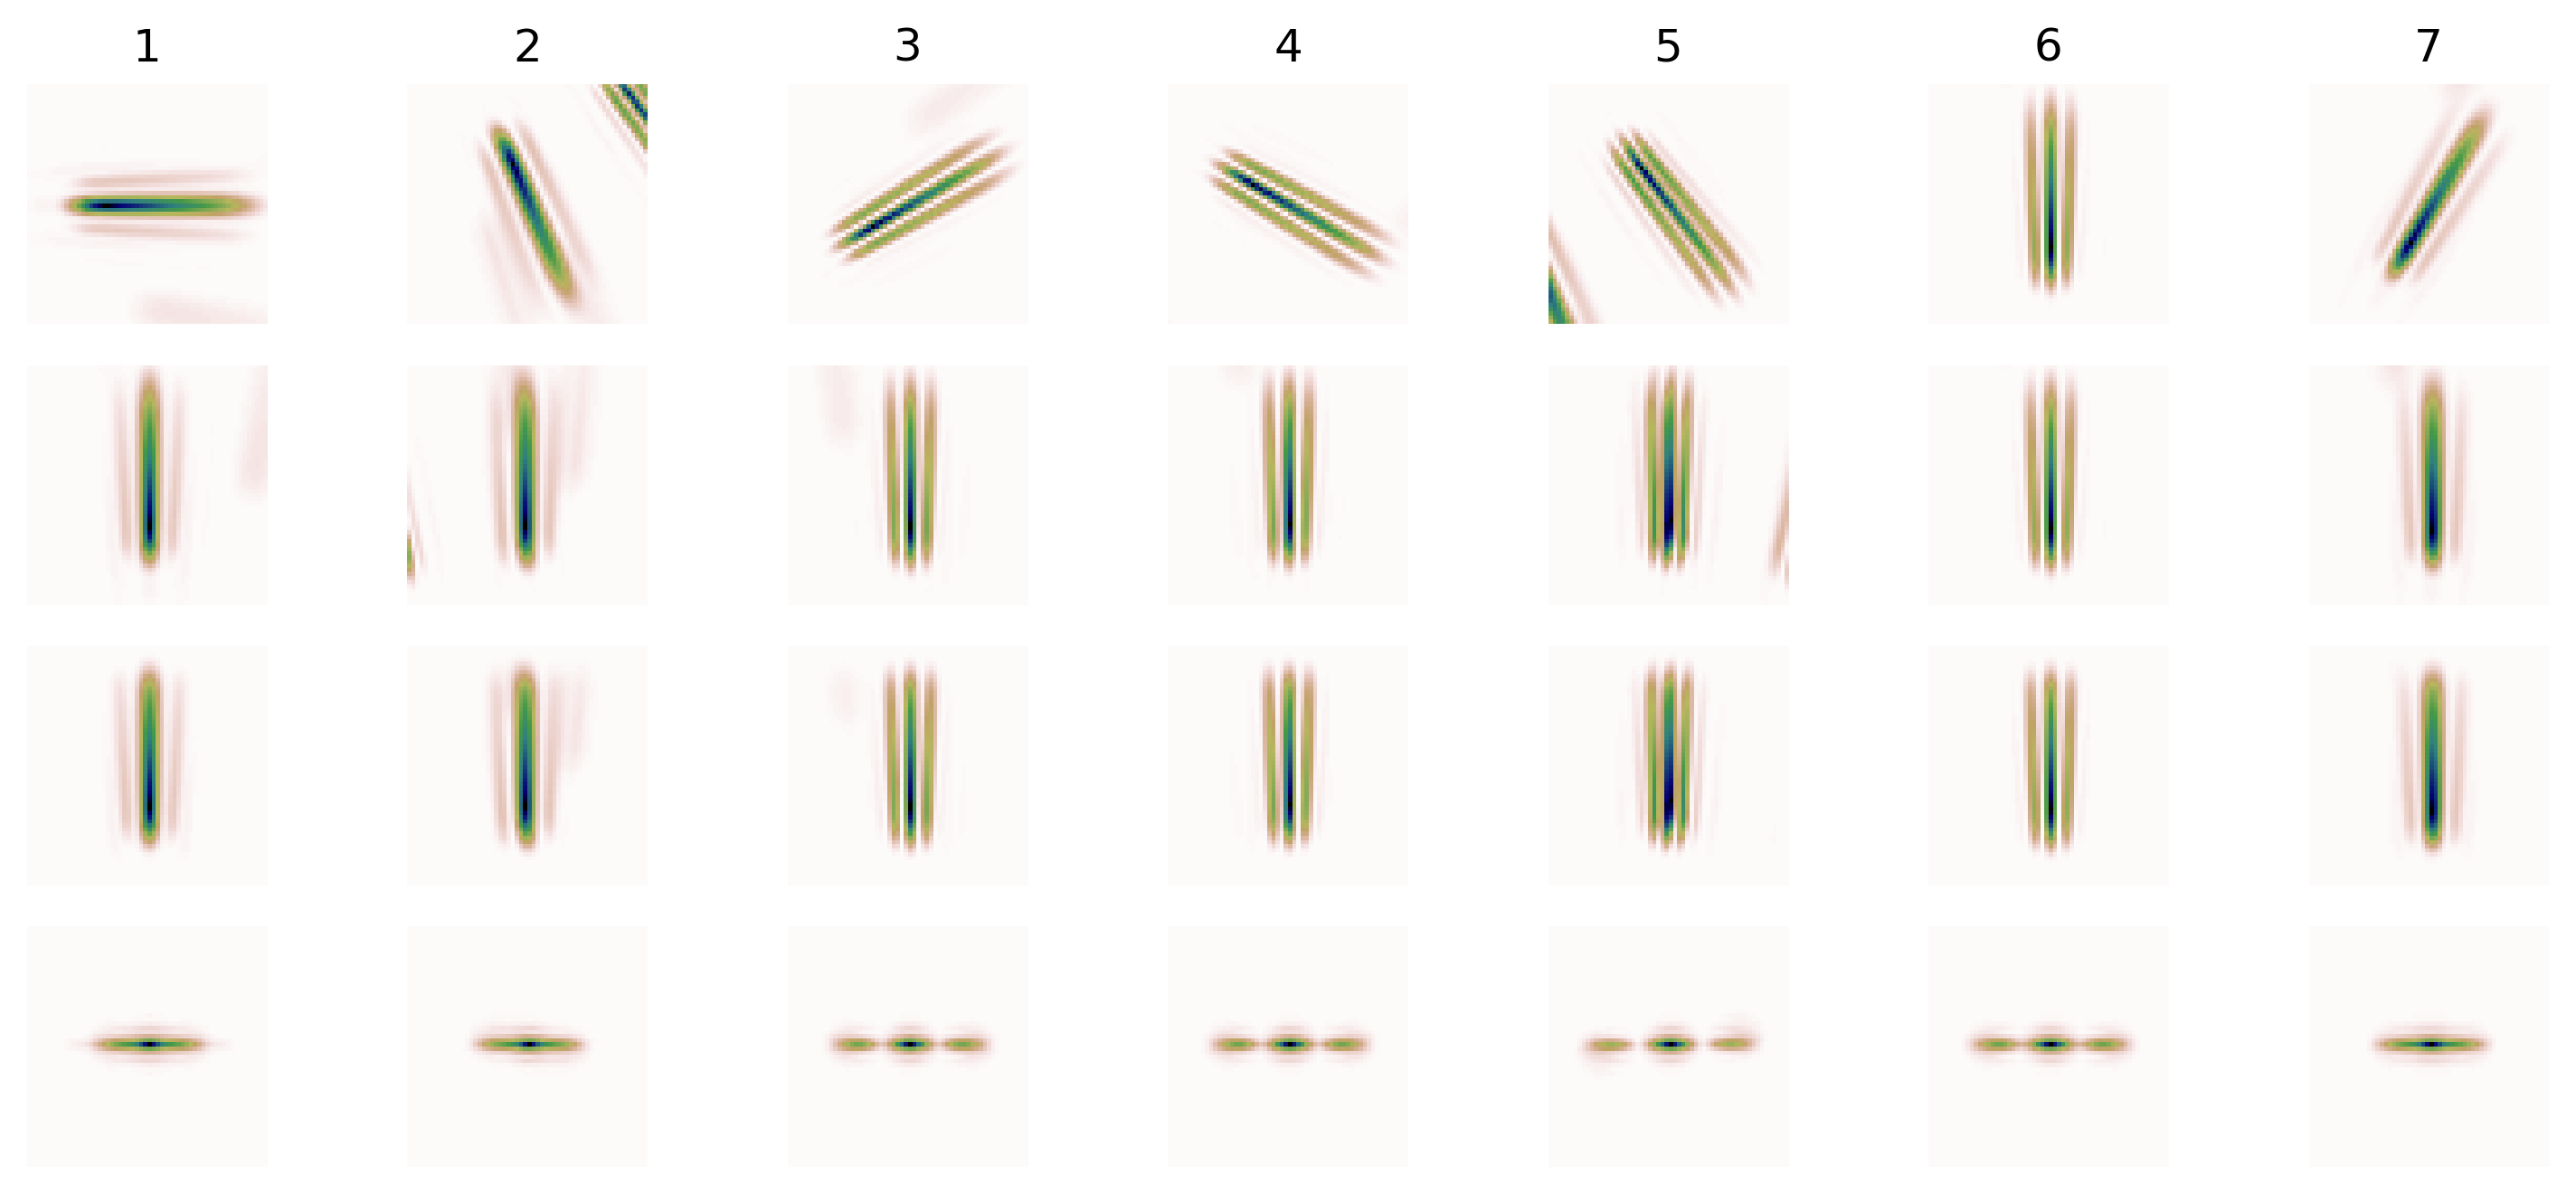

In [16]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(ncols=ps._N_FRINGES//2, nrows=4)
fig.set_size_inches((10,1.5*3))
fig.dpi = 300

show_fringes(fringes00, full=False, show_ids=True,  fig=fig, ax=ax1)
show_fringes(fringes01, full=False, show_ids=False, fig=fig, ax=ax2)
show_fringes(fringes02, full=False, show_ids=False, fig=fig, ax=ax3)
show_fftlets(full=False, show_ids=False, fig=fig, ax=ax4)

### Wavefront with segment piston errors

In [17]:
#-- Piston-scrambled WF data
pistscramble = np.array([ 2.82056940e-07,  8.56047645e-07, -6.94630029e-07,  -5.73606698e-07,
   -3.99178640e-07,  1.32922112e-07, -4.50824728e-07])*4

gmt.reset()
gmt.M1.motion_CS.origin[:,2] = pistscramble
gmt.M1.motion_CS.update()

gsps.reset()
ps.reset()
gmt.propagate(gsps)
ps.propagate(gsps)
ps.process()
mes = ps.get_measurement()

fringes03 = ps.extract_fringes(apodize=True, derotate=True)

absfft03 = []
for k in range(ps._N_FRINGES):
    absfft03 += [cp.fft.fftshift(cp.abs(cp.fft.fft2(fringes03[:,:,k]))).get()]

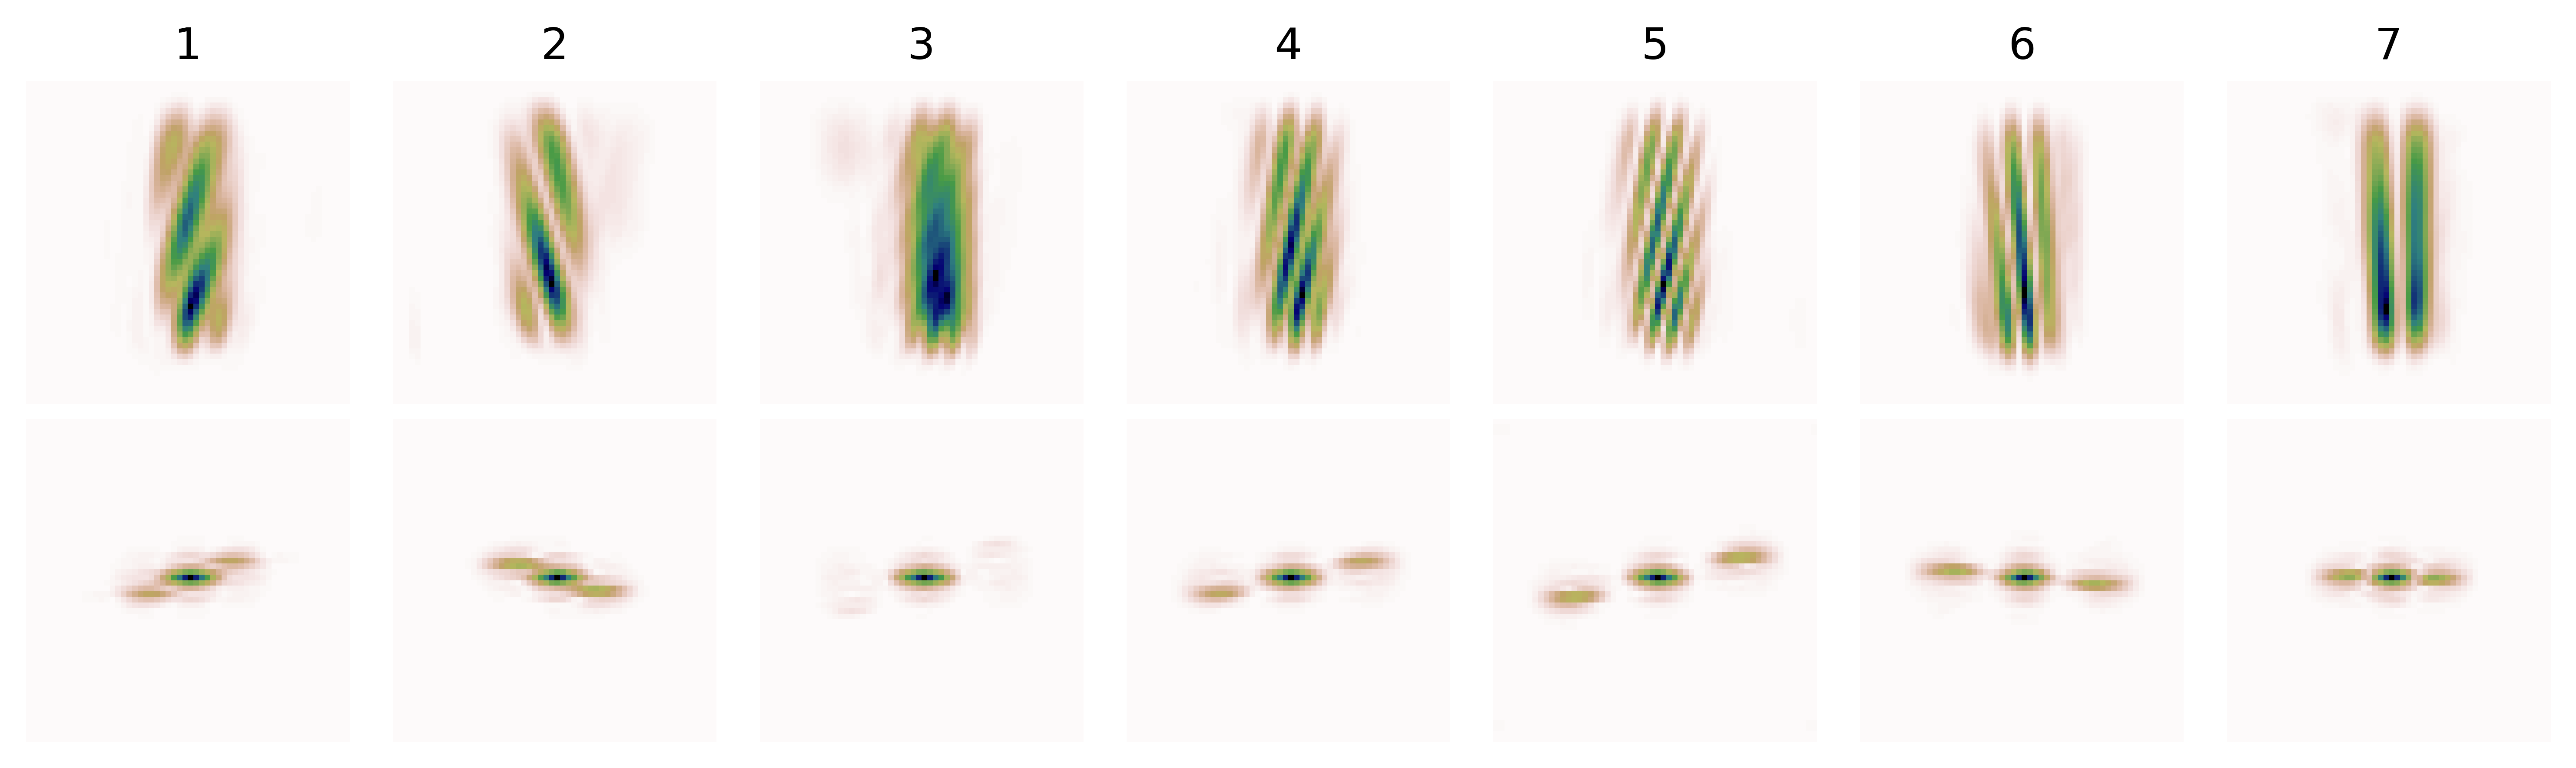

In [18]:
fig, (ax4,ax5) = plt.subplots(ncols=ps._N_FRINGES//2, nrows=2)
fig.set_size_inches((10,1.5*2))
fig.dpi = 600

show_fringes(fringes03, full=False, show_ids=True, fig=fig, ax=ax4)
show_fftlets(absfft03,  full=False, show_ids=False, fig=fig, ax=ax5)
fig.tight_layout()

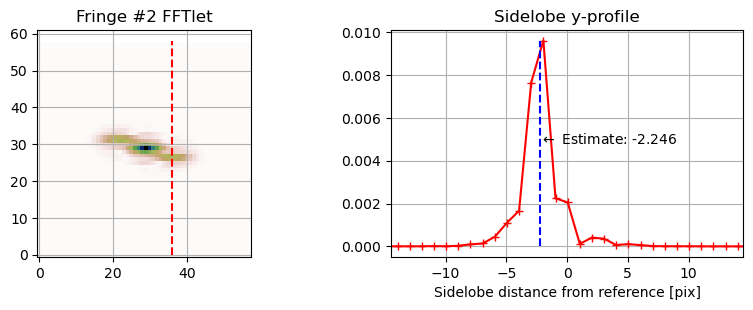

In [19]:
#--- Select FFTlet and show cut along sidelobe position (to show how segment piston changes the position of the sidelobe)
k=1

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
fig.dpi=100

ax1.imshow(absfft03[k], cmap=plt.cm.gist_earth_r, origin='lower')
ax1.plot([ps._sidelobeloc[k]]*2, [0,ps._fringe_subframe_pix],'r--')
ax1.grid()
ax1.set_title('Fringe #%d FFTlet'%(k+1))

sidelobe_profile = absfft03[k][:, ps._sidelobeloc[k]]
sidelobe_profvec = np.arange(ps._fringe_subframe_pix)
ax2.plot(sidelobe_profvec - ps.get_ref_measurement()[k], sidelobe_profile, 'r+-')
ax2.grid()
ax2.set_xlabel('Sidelobe distance from reference [pix]')
ax2.set_xlim([-ps._fringe_subframe_pix/4, ps._fringe_subframe_pix/4])
ax2.set_title('Sidelobe y-profile')

ax2.plot([mes[k]]*2, [0,np.max(sidelobe_profile)], 'b--')
ax2.text(mes[k], 0.5*np.max(sidelobe_profile), '$\leftarrow$ Estimate: %0.3f'%mes[k]);

# HDFS Photometry

In [20]:
#all three should be the same (photons/sec)
print(sps_throughput*    gsps.nPhoton[x]           *PupilArea * sps_flux_unitary_norm,
      sps_throughput*e0_wl2nd*10**(-0.4*sps_mag[0])*PupilArea * sps_flux_unitary_norm,
      ps._nph_per_sec * sps_flux_unitary_norm)

7603623.341594942 7603623.687214203 7732732.538179353


7732732.538179352


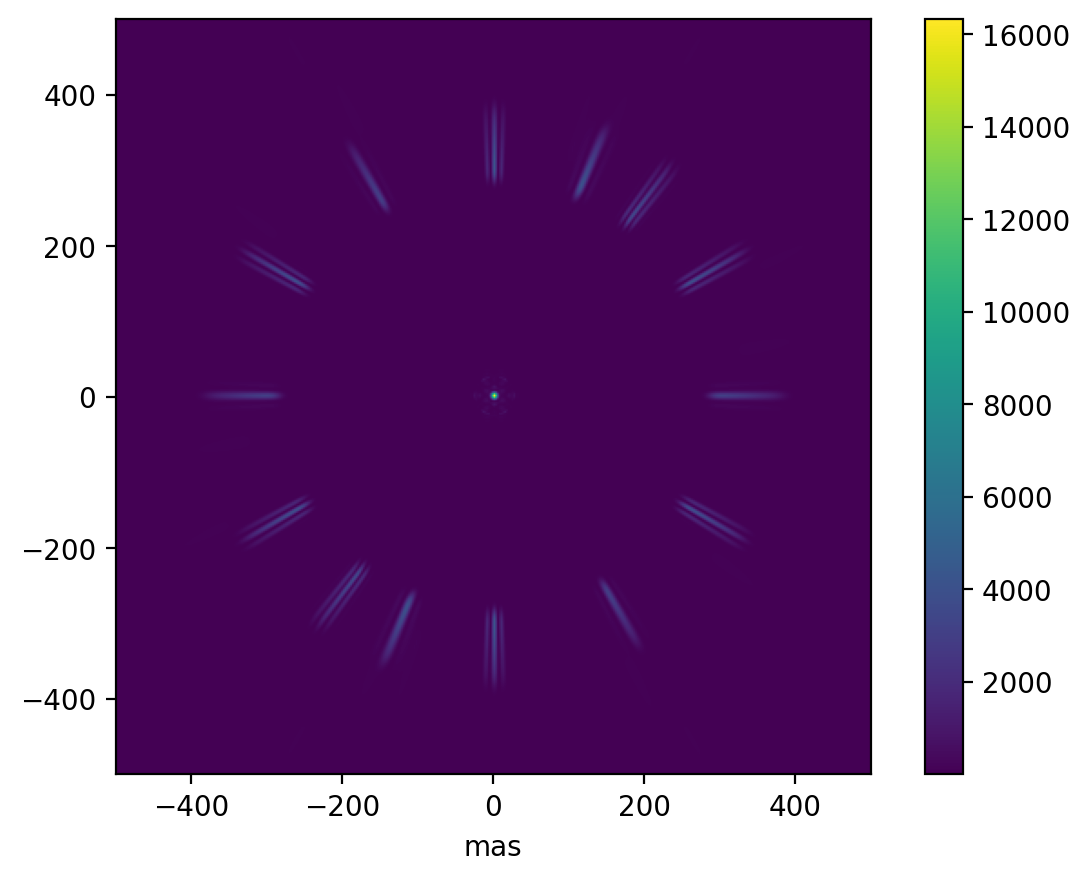

In [21]:
#---- Check flux normalization (noiseless readout)
gmt.reset()
gsps.reset()
gmt.propagate(gsps)
ps.reset()
ps.propagate(gsps)
ps.noiselessReadOut(1.0)

fig, ax1 = plt.subplots()
fig.set_size_inches((7,5))
fig.dpi = 200
imm1 = ax1.imshow(ps._image.get(), origin='lower',
        extent=[ps._im_range_mas[0],ps._im_range_mas[1],ps._im_range_mas[0],ps._im_range_mas[1]])
ax1.set_xlabel('mas')
clb1 = fig.colorbar(imm1, ax=ax1)

print(np.sum(ps._image.get()))

## Verify number of photons per SA per frame

In [22]:
#----- Estimate number of photons/SA/subframe:
def estimate_nphsspp(fringeCube=None):
    if fringeCube is None:
        fringeCube = ps.get_data_cube('camera')
    nphsspp = np.zeros(ps.get_measurement_size())
    for ii in range(ps.get_measurement_size()):
        nphsspp[ii] = np.sum(fringeCube[:,:,ii]) #/ (ps.camera.EM_gain * ps.camera.ADU_gain)
    nphsspp_mv = np.mean(nphsspp)
    nphsspp_std = np.std(nphsspp)
    #return (nphsspp_mv, nphsspp_std)
    return nphsspp

Acquire a single frame and check flux

In [24]:
sps_exposureTime   = 150e-3 # DFS camera integration time [seconds]
sspp_area = PupilArea / ps._N_FRINGES
nphsspp = sps_flux_unitary_norm*sps_throughput*e0_wl2nd*10**(-0.4*sps_mag[0])*sspp_area*sps_exposureTime  #ph/SA/frame
gmt.reset()
gsps.reset()
ps.reset()
gmt.propagate(gsps)
ps.propagate(gsps)
ps.noiselessReadOut(sps_exposureTime)
ps.process()
print('Number of expected photons per SA: %0.0f'%nphsspp)
print('Number of simulated photons per SA: %0.0f'%np.mean(estimate_nphsspp()))

Number of expected photons per SA: 81467
Number of simulated photons per SA: 70637


Simulate integration and check flux

In [25]:
gmt.reset()
gsps.reset()
gmt.propagate(gsps)
ps.reset()

sps_exposureTime = 150e-3  # this applies to the final readout (not each )
niter = 10
for jj in range(niter):
    ps.propagate(gsps)
ps.readOut(sps_exposureTime)
ps.process()
print('Number of simulated photons per SA: %0.0f'%np.mean(estimate_nphsspp()))

Number of simulated photons per SA: 70051


In [26]:
ps._HolographicDFS__n_integframes

10

In [27]:
ps.reset()
ps._HolographicDFS__n_integframes

0

## Test sky background computation

In [28]:
print("Sky background model: "+sps_sky_bkgd_model)

Sky background model: equivalent_sky_magnitude


 Expected background photons per second per arcsec^2: 2546.2
Calculating sky background assuming a sky magnitude of 19.6
Simulated background photons per second per arcsec^2: 2546.2

  Expected sum of background photons on image per second: 5.0
Estimated sum of background photons on image per second: 2.7


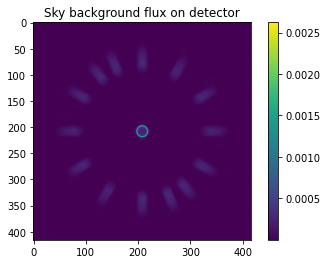

In [29]:
if sps_sky_bkgd_model == 'equivalent_sky_magnitude':
    ps.sky_mag = bkgd_mag
    bkgd_ph1 = e0_wl2nd * 10**(-0.4*ps.sky_mag) * ps._PupilArea * ps.throughput  #ph/s/arcsec^2
    print(" Expected background photons per second per arcsec^2: %0.1f"%bkgd_ph1)
    
elif sps_sky_bkgd_model == 'ESOmodel':
    ps.skybackground.airmass = 1./np.cos(np.radians(30.))   #should be equal to zen_angle

ps.set_sky_background(gsps, gmt, niter=100)
print("Simulated background photons per second per arcsec^2: %0.1f"%np.sum(ps._sky_spectral_flux))

plt.imshow(ps.camera.skyFlux.get())
plt.title('Sky background flux on detector')
plt.colorbar()

if sps_sky_bkgd_model == 'equivalent_sky_magnitude':
    
    if sps_fs_shape == 'none':
        bkgd_ph1_fov = bkgd_ph1 * (sps_fov)**2 #* flux_unitary_norm
    elif sps_fs_shape == 'round':
        bkgd_ph1_fov = bkgd_ph1 * np.pi/4*(sps_fs_dim_mas*1e-3)**2 
    elif sps_fs_shape == 'square':
        bkgd_ph1_fov = bkgd_ph1 * (sps_fs_dim_mas*1e-3)**2 
    print("\n  Expected sum of background photons on image per second: %0.1f"%(bkgd_ph1_fov))

print("Estimated sum of background photons on image per second: %0.1f"%(np.sum(ps.camera.skyFlux)))

## Estimate number of photons per SA per second vs star mag
Note: Flux estimation must be done on unrotated fringes to avoid artifacts

In [30]:
this_mag = [10,11,12,13,14]
nmag = len(this_mag)
nphsspp = cp.zeros((ps._N_FRINGES,nmag))
exposureTime = 1.0
gmt.reset()
for mm in range(nmag):
    gsps.magnitude = [this_mag[mm]]
    gsps.reset()
    gmt.propagate(gsps)
    ps.calibrate(gsps)
    ps.reset()
    ps.propagate(gsps)
    ps.noiselessReadOut(exposureTime)
    fringes = ps.extract_fringes(apodize=False, normalize=False, derotate=True)
    nphsspp[:,mm] = cp.sum(cp.reshape(fringes,(-1,ps._N_FRINGES)),axis=0)

print('R-mag:')
print(this_mag)
print('nph per SA per second:')
print(cp.array_str(cp.mean(nphsspp,axis=0),precision=1))

R-mag:
[10, 11, 12, 13, 14]
nph per SA per second:
[502647.9 200107.7  79664.3  31715.   12625.9]


# Simple segment piston estimation demo

## Calibrate interaction matrix
Using M1 segment piston (Tz) here.

In [31]:
poke = 1e-6
imat = np.zeros((ps._N_FRINGES,7))
for segID in range(7):
    gmt.reset()
    gmt.M1.motion_CS.origin[segID,2] = poke
    gmt.M1.motion_CS.update()
    gsps.reset()
    gmt.propagate(gsps)
    ps.reset()
    ps.propagate(gsps)
    ps.process()
    mes = ps.get_measurement()
    imat[:,segID] = mes/poke

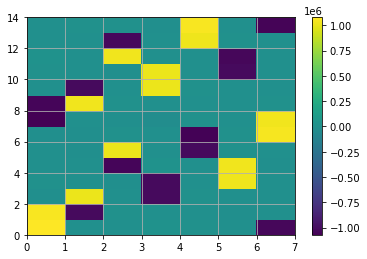

In [32]:
plt.pcolor(imat)
plt.colorbar()
plt.grid()

## Compute reconstruction matrix
Here is a simple LS rec

In [33]:
noise = np.zeros(ps._N_FRINGES)+1.
cnninv = np.diag(1./noise)
pistonpen = 1e15*np.ones((7,7))
cmat = np.linalg.solve(imat.T@cnninv@imat+pistonpen,imat.T@cnninv)

## Estimate a given static segment piston scramble

In [34]:
gsps.magnitude = [12.0]

gmt.reset()
gsps.reset()
gmt.propagate(gsps)
ps.reset()
ps.calibrate(gsps)

exposureTime = 150e-3

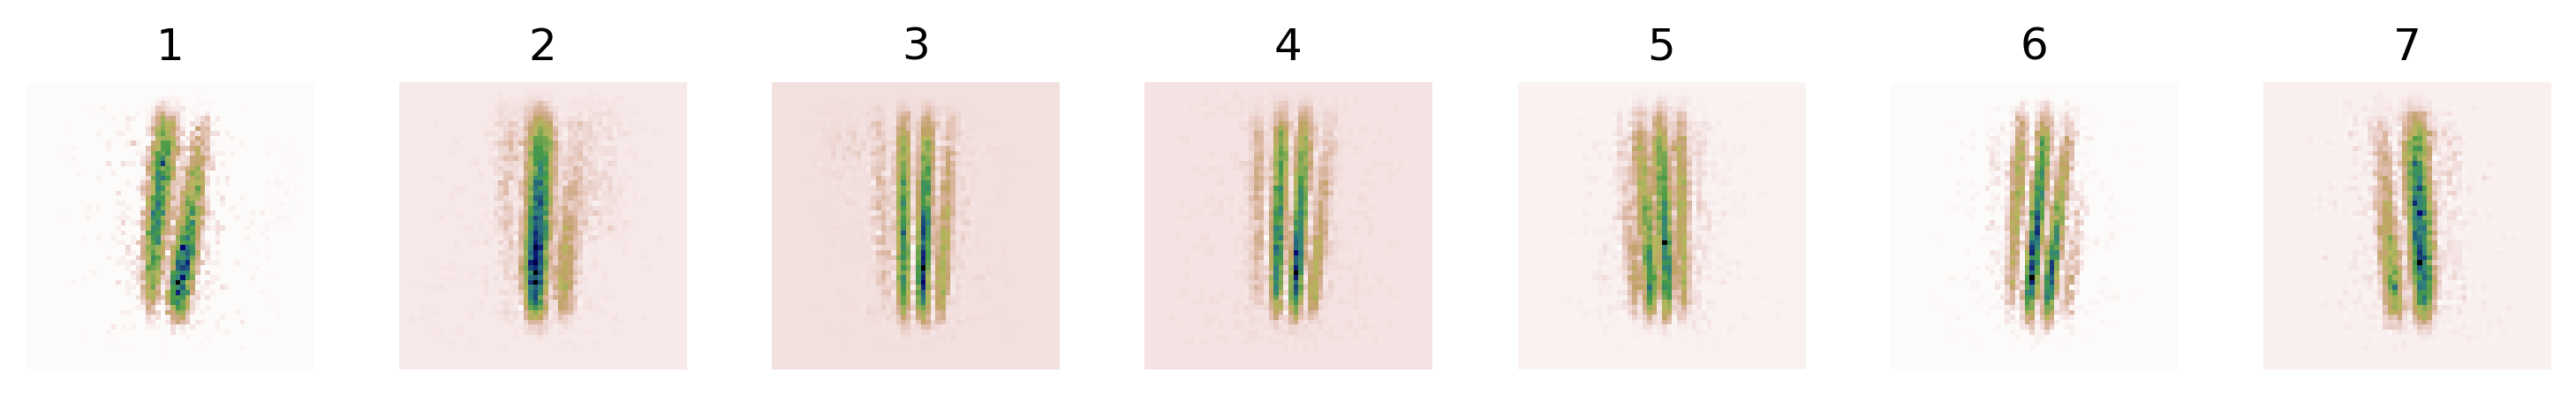

In [35]:
gmt.reset()
pistScramble = np.array([2.96428571e-07, -1.53571429e-07,  1.04642857e-06, -4.53571429e-07,-2.03571429e-07,  1.71428571e-07, -7.03571429e-07])
gmt.M1.motion_CS.origin[:,2] = pistScramble
gmt.M1.motion_CS.update()
gsps.reset()
gmt.propagate(gsps)
ps.reset()
ps.propagate(gsps)

#ps.noiselessReadOut(exposureTime)
ps.readOut(exposureTime)
ps.process()
mes = ps.get_measurement()
pistEst = cmat@mes

show_fringes(apodize=True, normalize=False, derotate=True, full=False)

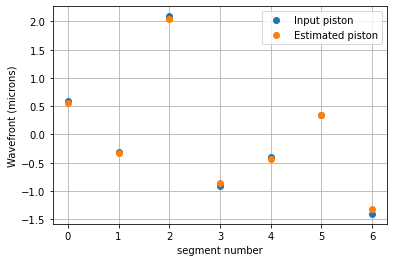

In [36]:
plt.plot(pistScramble*2e6,'o',label='Input piston')
plt.plot(pistEst*2e6,'o',label='Estimated piston')
plt.ylabel("Wavefront (microns)")
plt.xlabel("segment number")
plt.grid()
plt.legend()

# HDFS Capture range

In [37]:
#remove central segment column
D_M2_DFS = np.delete(imat,6,1)

R_M2_DFS = np.linalg.pinv(D_M2_DFS)
R_M2_DFS = np.insert(R_M2_DFS, 6, 0, axis=0)

In [38]:
exposureTime = 150e-3
pistin = np.arange(0,10e-6,250e-9)
niter = len(pistin)
pistout = np.zeros((7,niter))
for segID in range(6):
    gmt.reset()
    for jj in range(niter):
        gmt.M1.motion_CS.origin[segID,2] = pistin[jj]
        gmt.M1.motion_CS.update()
        gsps.reset()
        gmt.propagate(gsps)
        ps.reset()
        ps.propagate(gsps)

        ps.noiselessReadOut(exposureTime)
        #ps.readOut(exposureTime)
        ps.process()
        mes = ps.get_measurement()
        pistEst = R_M2_DFS@mes
        pistout[segID,jj] = pistEst[segID]

Text(0, 0.5, 'estimated segment piston [$\\mu$m WF]')

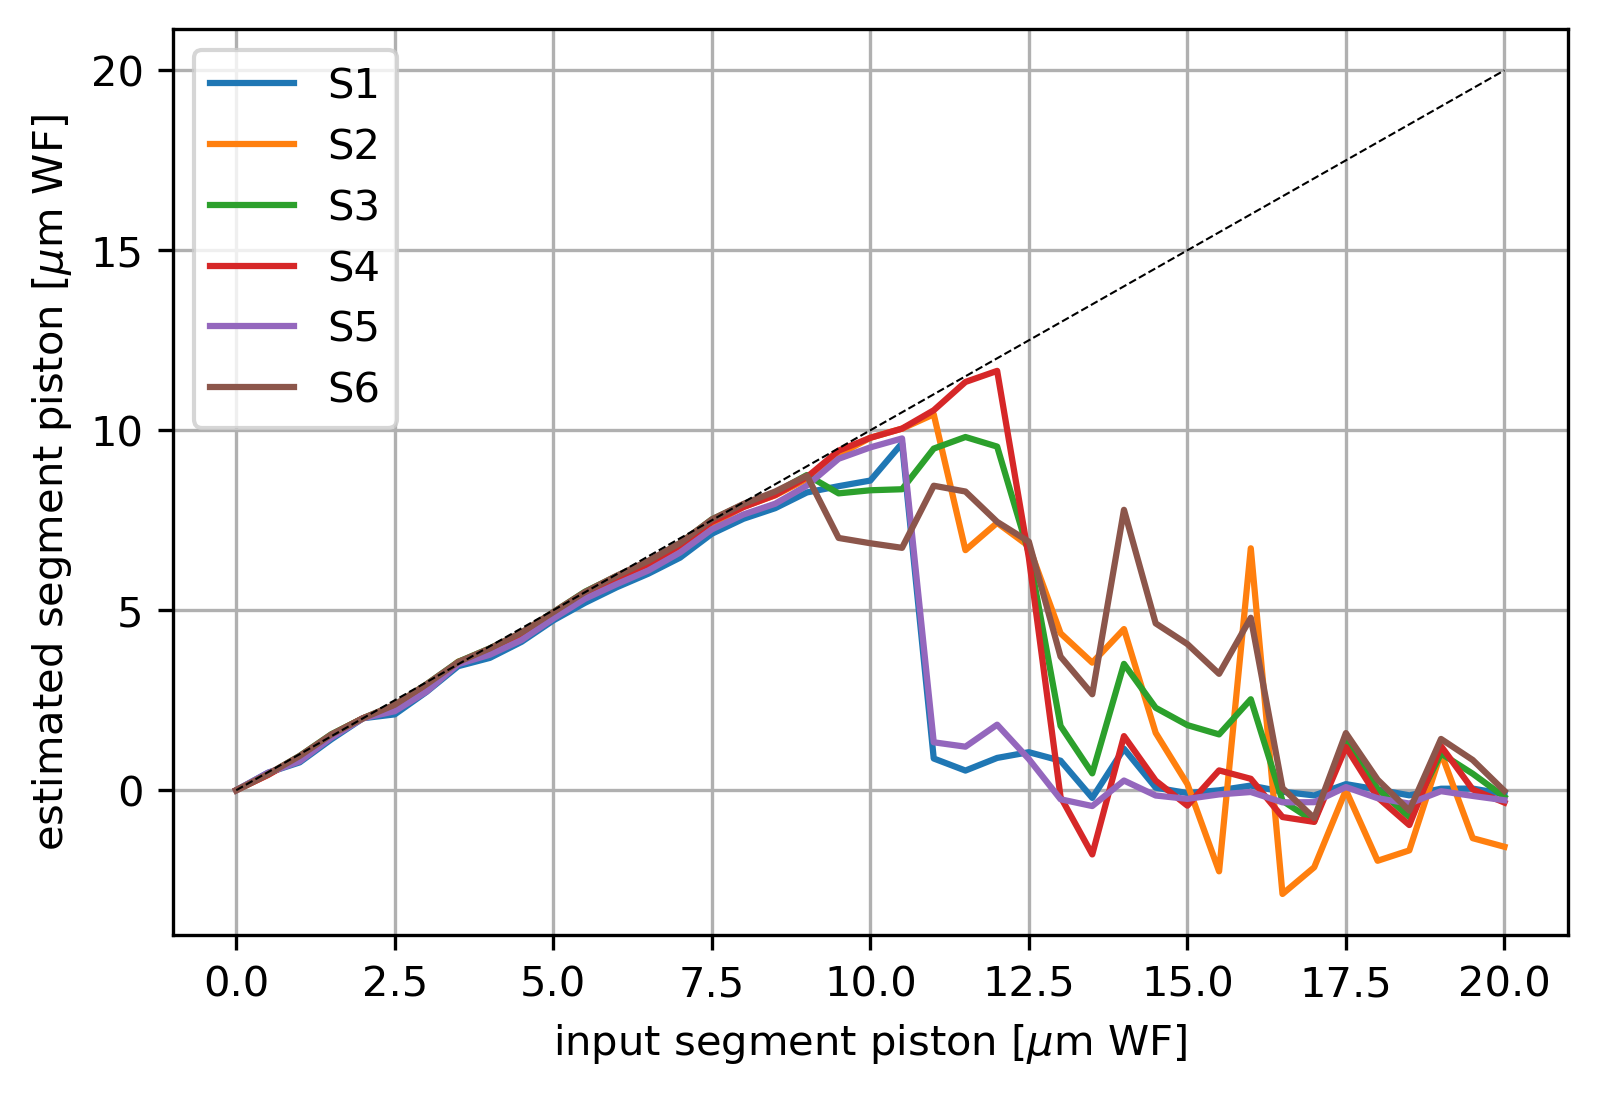

In [39]:
fig, ax = plt.subplots()
fig.dpi = 300
for segID in range(6):
    ax.plot(pistin*1e6*2, pistout[segID,:]*1e6*2, label='S'+str(segID+1))
ax.plot(pistin*1e6*2, pistin*1e6*2, 'k--', linewidth=0.5)
ax.grid()
ax.legend()
ax.set_xlabel('input segment piston [$\mu$m WF]')
ax.set_ylabel('estimated segment piston [$\mu$m WF]')
#ax.axis('square')

# Show additional HDFS stuff

## Apodization Function

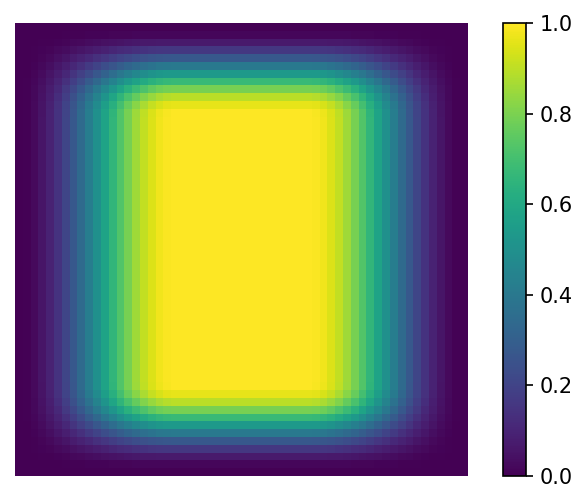

In [40]:
fig, ax = plt.subplots()
fig.dpi = 150
imm = ax.imshow(ps._apodization_window.get())
clb = fig.colorbar(imm, ax=ax)
ax.axis('off');

## Quantum efficiency curve

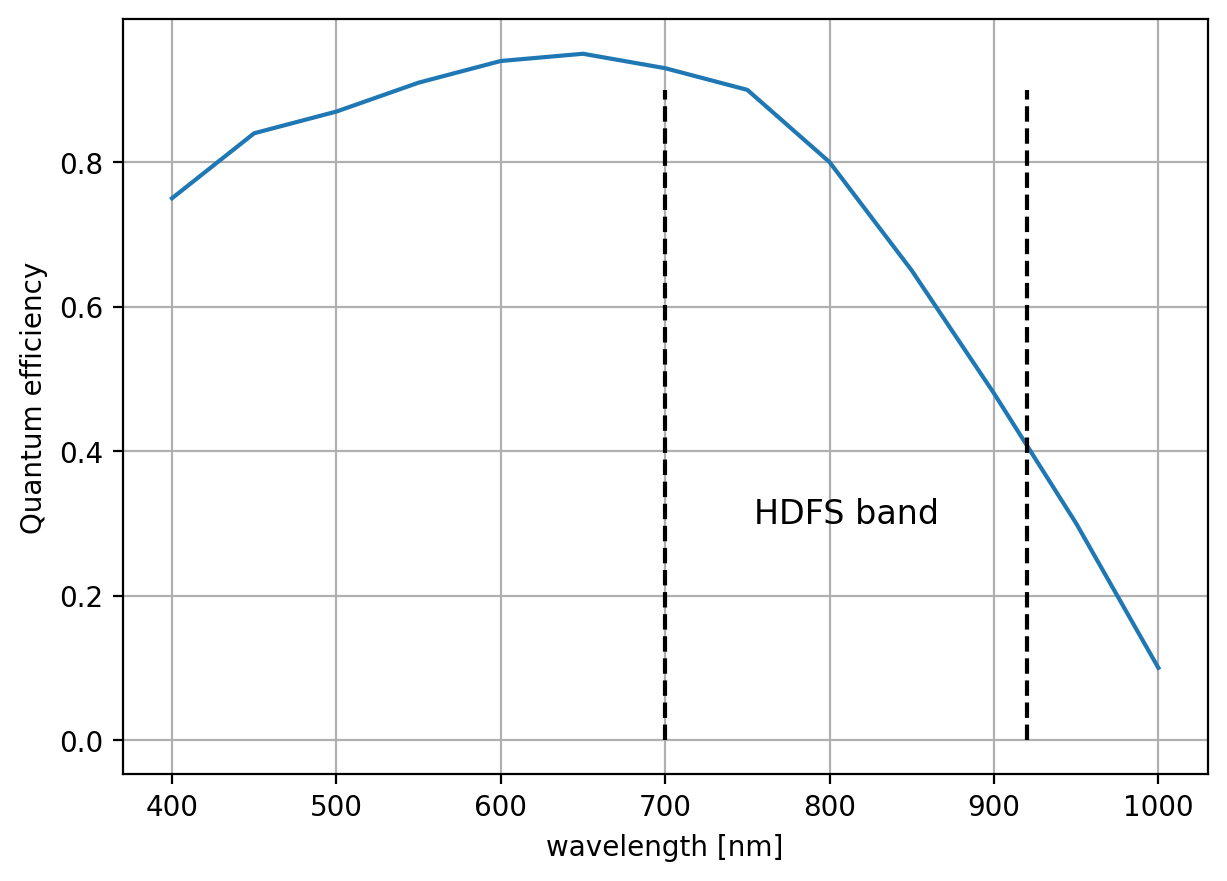

In [41]:
ccd_qe = [[400e-9,450e-9,500e-9,550e-9,600e-9,650e-9,700e-9,750e-9,800e-9,850e-9,900e-9,950e-9,1000e-9],[0.75,0.84,0.87,0.91,0.94,0.95,0.93,0.90,0.80,0.65,0.48,0.30,0.10]]
fig, ax = plt.subplots()
fig.set_size_inches((7,5))
fig.dpi=200
ax.plot(np.array(ccd_qe[0])*1e9, ccd_qe[1])
ax.plot([700,700], [0,0.9], 'k--')
ax.plot([920,920], [0,0.9], 'k--')
ax.text(810,0.3, 'HDFS band', horizontalalignment='center', fontsize='large')
ax.set_xlabel('wavelength [nm]', fontsize='medium')
ax.set_ylabel('Quantum efficiency', fontsize='medium')
ax.grid()